<a href="https://colab.research.google.com/github/noelmtv/Colab-Learning/blob/main/Portfolio_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Import libraries#
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
!pip install fredapi



In [29]:
#define the list of tickers#
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [30]:
#SET THE END DATE TO TODAY#
end_date = datetime.today()

In [31]:
#Set start date#
start_date = end_date - timedelta(days=10*365)
print(start_date)

2014-09-10 06:01:13.430622


In [32]:
#download adjusted close prices#
#This is done because you dont want to underweight a stock that pays out dividends#
adj_close_df = pd.DataFrame()

In [33]:
# Download the prices for each ticker#
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [34]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2014-09-10  167.461380  62.188995  120.260002   92.324318   86.874710
2014-09-11  167.653793  62.143353  119.470001   92.250549   87.034111
2014-09-12  166.674530  62.044434  118.379997   91.779984   86.472046
2014-09-15  166.548996  62.074883  118.639999   90.894302   86.245567
2014-09-16  167.804443  62.052048  118.830002   91.687721   86.857933
...                ...        ...         ...         ...         ...
2024-08-30  563.679993  74.134003  231.289993  476.269989  278.380005
2024-09-03  552.080017  74.449997  230.289993  461.809998  272.390015
2024-09-04  550.950012  74.779999  230.429993  460.609985  271.779999
2024-09-05  549.609985  74.959999  232.350006  461.040009  270.940002
2024-09-06  540.359985  75.050003  230.630005  448.690002  266.440002

[2515 rows x 5 columns]


**Step 3: Calculate the Lognormal Returns**

In [35]:
#Calculate the Lognormal returns for each ticker#
#Use lognormal because the returns are additive#
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [36]:
#drop missing values#
log_returns = log_returns.dropna()

**Step 4: Calculate the Covariance Matrix**

In [37]:
#helps us calculate standard deviation/risk in the most optimal way possible#
# MULTIPLY BY 252 TO ANNUALISE THE DAILY RETURNS#

cov_matrix = log_returns.cov() * 252
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.031368  0.000990  0.000973  0.035967  0.031887
BND  0.000990  0.002924  0.002779  0.001312  0.001077
GLD  0.000973  0.002779  0.020220  0.001493  0.001099
QQQ  0.035967  0.001312  0.001493  0.047724  0.036509
VTI  0.031887  0.001077  0.001099  0.036509  0.032682


**Section 5: Define portfolio Performance Metrics**

In [38]:
#calculate the portfolio standard deviation#
def standard_deviation(weights,cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


In [39]:
#Calculate Expected Returns using historical returns#
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [40]:
# calculate the Sharpe Ratio

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)


In [41]:
# Get the risk free rate

from fredapi import Fred
fred = Fred(api_key = '2b69fb669c856bbd11766d69b3894d6e')
ten_year_treasury_rate = fred.get_series('GS10')/100

#Set the risk free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)


0.0387


In [42]:
#Define the function to minimize (Negative Sharpe Ratio)
# In the case of scipy, there is no direct method to find the maximum value of a function so you gotta flip it.

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [43]:
#Set the constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = [(0,0.5) for _ in range(len(tickers))]

In [44]:
#Set the initial weights
initial_weights = np.array([1/len(tickers)] * len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [45]:
#optimize the weights to maximise the sharpe ratio

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate),
                                 method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = optimized_results.x

# Print the optimized weights
print("Optimized Weights:")
print(optimized_weights)

Optimized Weights:
[1.13572157e-01 0.00000000e+00 3.86427843e-01 5.00000000e-01
 7.02563008e-17]


**Analyse the optimal portfolio**

In [46]:
# Display the analytics of the optimal portfolio

for ticker, weight in zip(tickers, optimized_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimized_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimized_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Optimal Portfolio Return: {optimal_portfolio_return:.4f}")
print(f"Optimal Portfolio Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Optimal Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

SPY: 0.1136
BND: 0.0000
GLD: 0.3864
QQQ: 0.5000
VTI: 0.0000

Optimal Portfolio Return: 0.1178
Optimal Portfolio Volatility: 0.1418
Optimal Sharpe Ratio: 0.5579


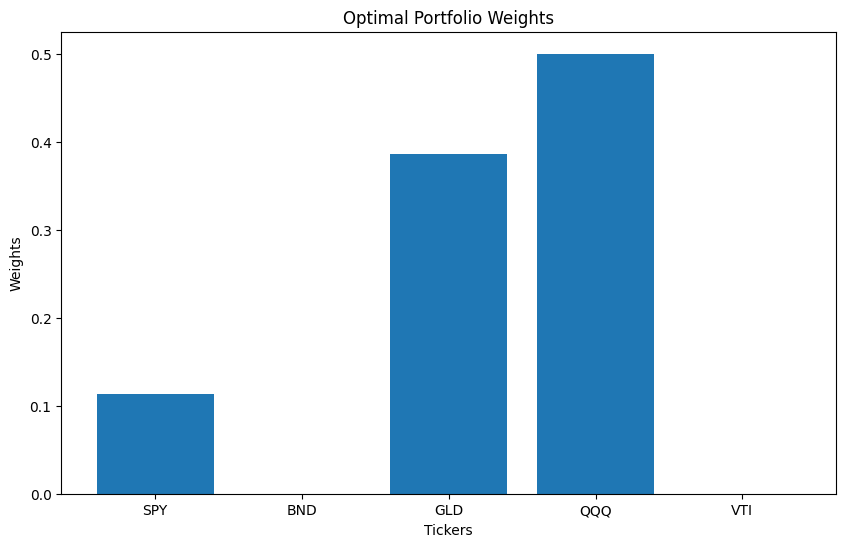

In [47]:
#display the final portfolio in a plot

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimized_weights)
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.title('Optimal Portfolio Weights')
plt.show()